# Predictions for Ocean Waves

In this example, we need to download both WeatherBench HREST0 data, and HRES-WAM data, that is data from ECMWF's ocean wave model called HRES-WAM. 

Running this notebook requires additional Python packages. You can install these as follows:

```
pip install ecmwf-api-client gcsfs zarr cfgrib matplotlib
```

## Downloading HRES-WAM From MARS

To begin with, register an account with [ECMWF](https://api.ecmwf.int/v1/key) and create `$HOME/.ecmwfapirc` with the following content:

```
{
    "url"   : "https://api.ecmwf.int/v1",
    "key"   : <API key>,
    "email" : <email>
}
```

You can find your API key on your account page.

We now download the HRES-WAM data.

In [1]:
from pathlib import Path

import ecmwfapi

# Data will be downloaded here.
download_path = Path("~/downloads")

download_path = download_path.expanduser()
download_path.mkdir(parents=True, exist_ok=True)

# Day to download. This will download all times for that day.
day = "2022-09-16"

# Set up the variables we want to download
variables: dict[str, str] = {
    "swh": "140229",  # Significant wave height
    "pp1d": "140231",  # Peak wave period
    "mwp": "140232",  # Mean wave period
    "mwd": "140230",  # Mean wave direction
    "shww": "140234",  # Significant height of wind waves
    "mdww": "140235",  # Mean direction of wind waves
    "mpww": "140236",  # Mean period of wind waves
    "shts": "140237",  # Significant height of total swell
    "mdts": "140238",  # Mean direction of total swell
    "mpts": "140239",  # Mean period of total swell
    "swh1": "140121",  # Significant wave height of first swell
    "mwd1": "140122",  # Mean direction of first swell
    "mwp1": "140123",  # Mean period of first swell
    "swh2": "140124",  # Significant wave height of second swell
    "mwd2": "140125",  # Mean wave direction of second swell
    "mwp2": "140126",  # Mean wave period of second swell
    "dwi": "140249",  # 10 m neutral wind direction
    "wind": "140245",  # 10 m neutral wind speed
}
# Convert to form required by MARS.
for k, v in variables.items():
    assert len(v) == 6
    variables[k] = v[3:6] + "." + v[0:3]

if not (download_path / f"{day}-wave.grib").exists():
    c = ecmwfapi.ECMWFService("mars")
    c.execute(
        f"""
        request,
            class=od,
            date={day}/to/{day},
            domain=g,
            expver=1,
            param={"/".join(variables.values())},
            stream=wave,
            time=00:00:00/06:00:00/12:00:00/18:00:00,
            grid=0.25/0.25,
            type=an,
            target="{day}-wave.grib"
        """,
        str(download_path / f"{day}-wave.grib"),
    )
print("HRES-WAM data downloaded!")

HRES-WAM data downloaded!


## Downloading HRES T0 from WeatherBench2

We need to download the corresponding data for the 16th of September 2022 from [WeatherBench2](https://weatherbench2.readthedocs.io/).

In [2]:
import fsspec
import xarray as xr

# We will download from Google Cloud.
url = "gs://weatherbench2/datasets/hres_t0/2016-2022-6h-1440x721.zarr"
ds = xr.open_zarr(fsspec.get_mapper(url), chunks=None)

# Download the surface-level variables. We write the downloaded data to another file to cache.
if not (download_path / f"{day}-surface-level.nc").exists():
    surface_vars = [
        "10m_u_component_of_wind",
        "10m_v_component_of_wind",
        "2m_temperature",
        "mean_sea_level_pressure",
    ]
    ds_surf = ds[surface_vars].sel(time=day).compute()
    ds_surf.to_netcdf(str(download_path / f"{day}-surface-level.nc"))
print("Surface-level variables downloaded!")

# Download the atmospheric variables. We write the downloaded data to another file to cache.
if not (download_path / f"{day}-atmospheric.nc").exists():
    atmos_vars = [
        "temperature",
        "u_component_of_wind",
        "v_component_of_wind",
        "specific_humidity",
        "geopotential",
    ]
    ds_atmos = ds[atmos_vars].sel(time=day).compute()
    ds_atmos.to_netcdf(str(download_path / f"{day}-atmospheric.nc"))
print("Atmospheric variables downloaded!")

Surface-level variables downloaded!
Atmospheric variables downloaded!


## Downloading the Static Variables

For this model, we also need to include the correct static variables. We have made these available on [HuggingFace](https://huggingface.co/microsoft/aurora).

In [3]:
from huggingface_hub import hf_hub_download

# Download the static variables from HuggingFace.
static_path = hf_hub_download(
    repo_id="microsoft/aurora",
    filename="aurora-0.25-wave-static.pickle",
)
print("Static variables downloaded!")

/home/wbruinsma/miniforge3/envs/aurora/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Static variables downloaded!


## Preparing a Batch

We convert the downloaded data to an `aurora.Batch`, which is what the model requires. In this case, the data is a combination of HREST0 data, and HRES-WAM data to capture ocean-wave variables.

In [4]:
import pickle

import numpy as np
import torch
import xarray as xr

from aurora import Batch, Metadata

with open(static_path, "rb") as f:
    static_vars = pickle.load(f)
surf_vars_ds = xr.open_dataset(
    download_path / f"{day}-surface-level.nc",
    engine="netcdf4",
    decode_timedelta=True,
)
wave_vars_ds = xr.open_dataset(
    download_path / f"{day}-wave.grib",
    engine="cfgrib",
    backend_kwargs={"indexpath": ""},
)
atmos_vars_ds = xr.open_dataset(
    download_path / f"{day}-atmospheric.nc",
    engine="netcdf4",
    decode_timedelta=True,
)


def _prepare_hres(x: np.ndarray) -> torch.Tensor:
    """Prepare an HRES variable from WeatherBench2.

    This does the following things:
    * Select the first two time steps: 00:00 and 06:00.
    * Insert an empty batch dimension with `[None]`.
    * Flip along the latitude axis to ensure that the latitudes are decreasing.
    * Copy the data, because the data must be contiguous when converting to PyTorch.
    * Convert to PyTorch.
    """
    return torch.from_numpy(x[:2][None][..., ::-1, :].copy())


def _prepare_wave(x: np.ndarray) -> torch.Tensor:
    """Prepare a wave variable.

    This does the following things:
    * Select the first two time steps: 00:00 and 06:00.
    * Insert an empty batch dimension with `[None]`.
    """
    return torch.from_numpy(x[:2][None])


batch = Batch(
    surf_vars={
        "2t": _prepare_hres(surf_vars_ds["2m_temperature"].values),
        "10u": _prepare_hres(surf_vars_ds["10m_u_component_of_wind"].values),
        "10v": _prepare_hres(surf_vars_ds["10m_v_component_of_wind"].values),
        "msl": _prepare_hres(surf_vars_ds["mean_sea_level_pressure"].values),
        "swh": _prepare_wave(wave_vars_ds["swh"].values),
        "mwd": _prepare_wave(wave_vars_ds["mwd"].values),
        "mwp": _prepare_wave(wave_vars_ds["mwp"].values),
        "pp1d": _prepare_wave(wave_vars_ds["pp1d"].values),
        "shww": _prepare_wave(wave_vars_ds["shww"].values),
        "mdww": _prepare_wave(wave_vars_ds["mdww"].values),
        "mpww": _prepare_wave(wave_vars_ds["mpww"].values),
        "shts": _prepare_wave(wave_vars_ds["shts"].values),
        "mdts": _prepare_wave(wave_vars_ds["mdts"].values),
        "mpts": _prepare_wave(wave_vars_ds["mpts"].values),
        "swh1": _prepare_wave(wave_vars_ds["swh1"].values),
        "mwd1": _prepare_wave(wave_vars_ds["mwd1"].values),
        "mwp1": _prepare_wave(wave_vars_ds["mwp1"].values),
        "swh2": _prepare_wave(wave_vars_ds["swh2"].values),
        "mwd2": _prepare_wave(wave_vars_ds["mwd2"].values),
        "mwp2": _prepare_wave(wave_vars_ds["mwp2"].values),
        "wind": _prepare_wave(wave_vars_ds["wind"].values),
        "dwi": _prepare_wave(wave_vars_ds["dwi"].values),
    },
    static_vars={k: torch.from_numpy(v) for k, v in static_vars.items()},
    atmos_vars={
        "t": _prepare_hres(atmos_vars_ds["temperature"].values),
        "u": _prepare_hres(atmos_vars_ds["u_component_of_wind"].values),
        "v": _prepare_hres(atmos_vars_ds["v_component_of_wind"].values),
        "q": _prepare_hres(atmos_vars_ds["specific_humidity"].values),
        "z": _prepare_hres(atmos_vars_ds["geopotential"].values),
    },
    metadata=Metadata(
        # Flip the latitudes from WeatherBench2! We need to copy because converting
        # to PyTorch, because the data must be contiguous.
        lat=torch.from_numpy(surf_vars_ds.latitude.values[::-1].copy()),
        lon=torch.from_numpy(surf_vars_ds.longitude.values),
        # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        # `datetime.datetime`s. Note that this needs to be a tuple of length one:
        # one value for every batch element. Select element 1, corresponding to time
        # 06:00.
        time=(surf_vars_ds.time.values.astype("datetime64[s]").tolist()[1],),
        atmos_levels=tuple(int(level) for level in atmos_vars_ds.level.values),
    ),
)

/home/wbruinsma/miniforge3/envs/aurora/lib/python3.10/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


## Loading and Running the Model

Finally, we are ready to load and run the model and visualise the predictions. We perform a roll-out for two steps, which produces predictions for hours 12:00 and 18:00.

Note that some specific postprocessing is required for the HRES-WAM data. See Section C.5 of the [Supplementary Information](https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-025-09005-y/MediaObjects/41586_2025_9005_MOESM1_ESM.pdf).

In [5]:
from aurora import AuroraWave, rollout

model = AuroraWave()
model.load_checkpoint()

model.eval()
model = model.to("cuda")

with torch.inference_mode():
    preds = [pred.to("cpu") for pred in rollout(model, batch, steps=2)]

model = model.to("cpu")

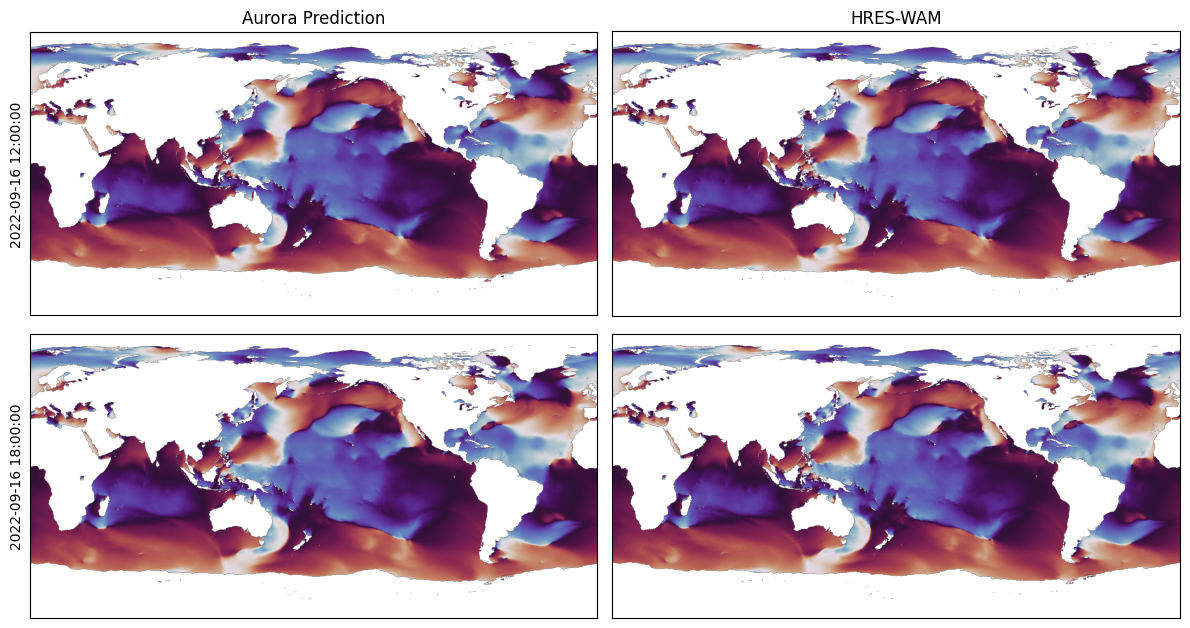

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 6.5))

for i in range(axs.shape[0]):
    pred = preds[i]

    ax = axs[i, 0]
    ax.imshow(pred.surf_vars["mwd"][0, 0].numpy(), vmin=0, vmax=360, cmap="twilight")
    ax.set_ylabel(str(pred.metadata.time[0]))
    if i == 0:
        ax.set_title("Aurora Prediction")
    ax.set_xticks([])
    ax.set_yticks([])

    ax = axs[i, 1]
    ref = wave_vars_ds["mwd"][2 + i].values
    # If the wave has practically zero magnitude, we say that the wave direction is missing.
    # See Section C.5 of the Supplementary Information.
    ref[wave_vars_ds["swh"][2 + i].values < 1e-4] = np.nan
    ax.imshow(ref, vmin=0, vmax=360, cmap="twilight")
    if i == 0:
        ax.set_title("HRES-WAM")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()